# Telcom Churn Predictions

## Overview
Customer churn in the telcom industry is a big problem for service providers. As it is expensive to accuire new customers, keeping existing customers is a priority. This project aims to predict future churners so the company can take steps to retain them. Using company provided data we tried varuous Machine Learning models to 
make predictions, and chose the results from the best one. Our results show a recall score of .76

## Business Understanding
As it is very expensive for a telcom to accuire a new customer, every effort is made to retain it's existing customers. If we could identify customers that will leave the company can take steps to retain them. Even if there is a cost associated with the retention efforts, it is lower than the acquisition of a new customer.
Since there is a cost associated with losing a customer and getting a new one the company has determined the priority to be identifying all possible churners. For this reason we will use Recall score as our success metric.


In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import os

# For x86
#import xgboost
#from xgboost import XGBClassifier

# For ARM
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier



## Getting The Data

The data set we used was provided by Kaggle. *https://www.kaggle.com/becksddf/churn-in-telecoms-dataset*

To run this notebook successfully you will need to download data from Kaggle. A Kaggle account with an API key is required to follow these steps.

1. Create Kaggle account
2. Go to your Kaggle account settings (https://www.kaggle.com/account)
3. Scroll down to the API section and click on Create New API Token
3. Save API key to the computer where this notebook will run
4. Run the cell below to download the data
5. In the cell follwing uncomment either the Linix or Window command depending on your OS

In [2]:
import kaggle
kaggle.api.authenticate()

kaggle.api.dataset_download_files('becksddf/churn-in-telecoms-dataset', path='zippedData/', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/becksddf/churn-in-telecoms-dataset


In [4]:
# Rename the downloaded file to match the expected name
# This is necessary because the Kaggle API does not allow us to specify the filename directly.

# For Linux/Unix
#!mv zippedData/bigml_59c28831336c6604c800002a.csv  zippedData/telecom_churn.csv

# For Windows, you can use the following command:
# zippedData\bigml_59c28831336c6604c800002a.csv zippedData\telecom_churn.csv

df = pd.read_csv('zippedData/telecom_churn.csv')


## Data Understanding

The data set we used was provided by Kaggle. *https://www.kaggle.com/becksddf/churn-in-telecoms-dataset* 
The dataset contains information about customers of a telecom company, including their demographics, 
account information, and whether they have churned (i.e., stopped using the service). 

The data set have 3333 records with 21 attributes. Our feature engineering will add 2 additional attributes.
There are no missing values in the data set. However there is a data imbalance with poisitive cases (customers 
that churned) being only 14% of the total records.




## EDA and Data Preprocessing
As this is a clssification problem we've encoded non numeric attributes. To address the data imbalance we've used stratified random sampling to preserve the ratio of positive cases. 

For feature engineering weve created 2  new columns. "Help rate" is the number of calls to customer service divided by the length of the account. "Charge Per Call" was generated by adding up all charges and dividing by the number of calls and multiplying by 100.

The "Phone Number" cateogory was dropped as we deemed it useless.

The remaingin data was split into Train and Test datasets with 80% to 20% respectively.


In [5]:
df.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [6]:
df.columns

Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')

In [7]:
df['churn'].value_counts()
# 483/3333 = 0.145 15% positive imbalance

churn
False    2850
True      483
Name: count, dtype: int64

In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [9]:
# Feature Engineering
df ['help rate'] = (df['customer service calls'] / df['account length']) * 100
df['total charge'] = df['total day charge'] + df['total eve charge'] + df['total night charge'] + df['total intl charge']
df['total calls'] = df['total day calls'] + df['total eve calls'] + df['total night calls'] + df['total intl calls']
df['charge per call'] = df['total charge'] / df['total calls']

In [10]:
# Data Pre Processing
df['voice mail plan'] = df['voice mail plan'].astype('category')
df['voice mail plan'] = df['voice mail plan'].cat.codes 
df['international plan'] = df['international plan'].astype('category')
df['international plan'] = df['international plan'].cat.codes   
df['churn'] = df['churn'].astype('category')
df['churn'] = df['churn'].cat.codes
df['state'] = df['state'].astype('category')
df['state'] = df['state'].cat.codes


In [11]:
# Droping columns
df = df.drop('phone number', axis=1)
df = df.drop('total charge', axis=1)
df

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,...,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,help rate,total calls,charge per call
0,16,128,415,0,1,25,265.1,110,45.07,197.4,...,91,11.01,10.0,3,2.70,1,0,0.781250,303,0.249373
1,35,107,415,0,1,26,161.6,123,27.47,195.5,...,103,11.45,13.7,3,3.70,1,0,0.934579,332,0.178434
2,31,137,415,0,0,0,243.4,114,41.38,121.2,...,104,7.32,12.2,5,3.29,0,0,0.000000,333,0.187057
3,35,84,408,1,0,0,299.4,71,50.90,61.9,...,89,8.86,6.6,7,1.78,2,0,2.380952,255,0.261961
4,36,75,415,1,0,0,166.7,113,28.34,148.3,...,121,8.41,10.1,3,2.73,3,0,4.000000,359,0.145097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,3,192,415,0,1,36,156.2,77,26.55,215.5,...,83,12.56,9.9,6,2.67,2,0,1.041667,292,0.205822
3329,49,68,415,0,0,0,231.1,57,39.29,153.4,...,123,8.61,9.6,4,2.59,3,0,4.411765,239,0.265816
3330,39,28,510,0,0,0,180.8,109,30.74,288.8,...,91,8.64,14.1,6,3.81,2,0,7.142857,264,0.256591
3331,6,184,510,1,0,0,213.8,105,36.35,159.6,...,137,6.26,5.0,10,1.35,2,0,1.086957,336,0.171220


In [12]:
# Set up train and test data
X = df.drop('churn', axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)


## Model 1 Decision Tree
For the first model we've use a DecisionTree classifier with a max depth of 8. This prodiced better results than a max depth of 10.
For the target attribute this produced a recall score of .64

In [13]:
c_gini = DecisionTreeClassifier(max_depth=8, random_state=42)
c_gini.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, random_state=42)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       570
           1       0.83      0.64      0.72        97

    accuracy                           0.93       667
   macro avg       0.88      0.81      0.84       667
weighted avg       0.92      0.93      0.92       667



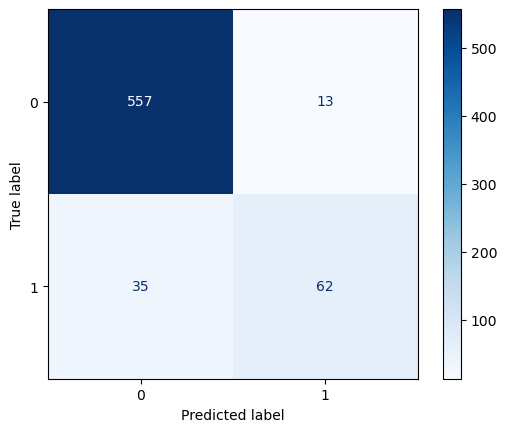

In [14]:
y_hat = c_gini.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,
                              display_labels=c_gini.classes_)
print(classification_report(y_test, y_hat))
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [15]:
print(f'Accuracy score: {accuracy_score(y_test, y_hat)} \n') 
print(f'Recall score: {recall_score(y_test, y_hat)} \n')


Accuracy score: 0.9280359820089955 

Recall score: 0.6391752577319587 



## Model 2 XGBoost
Here we used an untrained XGBoost model with a max depth of 8, 100 estimators and a learning rate of .1
This model produced a target recall score of .72

In [16]:
clf = XGBClassifier(max_depth=8, n_estimators=100, learning_rate=0.1, random_state=42)
clf.fit(X_train, y_train)
y_hat_train_xgb= clf.predict(X_train)
y_hat_test_xgb= clf.predict(X_test)

train_acc_xgb = accuracy_score(y_train, y_hat_train_xgb)
test_acc_xgb = accuracy_score(y_test, y_hat_test_xgb)
print(f"XGBoost Train Accuracy: {train_acc_xgb}")
print(f"XGBoost Test Accuracy: {test_acc_xgb}")

XGBoost Train Accuracy: 0.9996249062265566
XGBoost Test Accuracy: 0.9505247376311844


              precision    recall  f1-score   support

           0       0.95      0.99      0.97       570
           1       0.92      0.72      0.81        97

    accuracy                           0.95       667
   macro avg       0.94      0.86      0.89       667
weighted avg       0.95      0.95      0.95       667



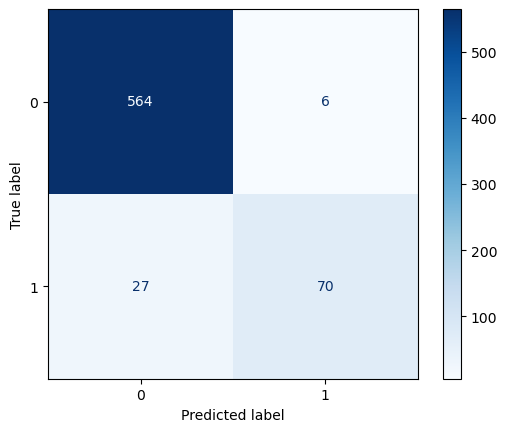

In [17]:
clf_matrix = confusion_matrix(y_test, y_hat_test_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=clf_matrix,
                              display_labels=clf.classes_)
print(classification_report(y_test, y_hat_test_xgb))
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [18]:
print(f'Accuracy score: {accuracy_score(y_test, y_hat_test_xgb)} \n') 
print(f'Recall score: {recall_score(y_test, y_hat_test_xgb)} \n')


Accuracy score: 0.9505247376311844 

Recall score: 0.7216494845360825 



## Model 3 MLP Classifier
The MLP Classifier may work with some tabular data, but we saw poor results in precision and recall.

In [19]:
## Model 3 MLP
from sklearn.neural_network import MLPClassifier    
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)   
y_hat_train_mlp = mlp.predict(X_train)
y_hat_test_mlp = mlp.predict(X_test)    
train_acc_mlp = accuracy_score(y_train, y_hat_train_mlp)
test_acc_mlp = accuracy_score(y_test, y_hat_test_mlp)
print(f"MLP Train Accuracy: {train_acc_mlp}")
print(f"MLP Test Accuracy: {test_acc_mlp}")

MLP Train Accuracy: 0.8833458364591148
MLP Test Accuracy: 0.8710644677661169


0.8710644677661169
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       570
           1       0.76      0.16      0.27        97

    accuracy                           0.87       667
   macro avg       0.82      0.58      0.60       667
weighted avg       0.86      0.87      0.83       667



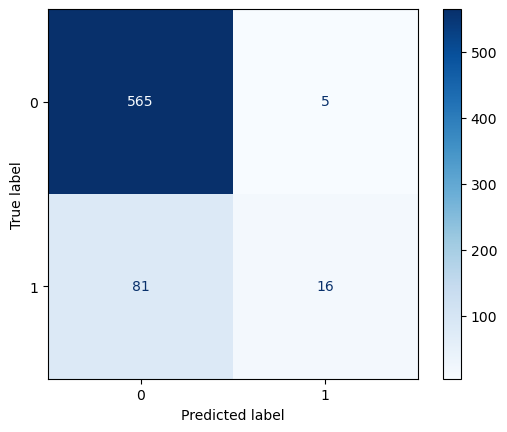

In [20]:
clm_matrix = confusion_matrix(y_test, y_hat_test_mlp)
disp = ConfusionMatrixDisplay(confusion_matrix=clm_matrix,
                              display_labels=mlp.classes_)
print(accuracy_score(y_test, y_hat_test_mlp))
print(classification_report(y_test, y_hat_test_mlp))
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [21]:
print(f'Accuracy score: {accuracy_score(y_test, y_hat_test_mlp)} \n') 
print(f'Recall score: {recall_score(y_test, y_hat_test_mlp)} \n')


Accuracy score: 0.8710644677661169 

Recall score: 0.16494845360824742 



## Tuned XGBoost model
By tuning the XGBoost model we were able to improve on the target metric. Using a learning rate of .2, a max depth of 10 and 100 estimators this model had a recall of .74

In [64]:
param_grid = {
    'max_depth': [12, 14],
    'n_estimators': [145, 150],
    'learning_rate': [0.3, 0.35],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [.9, 1.0]
}

In [65]:
clg = XGBClassifier(
objective='binary:logistic')

grid_search = GridSearchCV(clg, param_grid, scoring='recall', cv=10, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=No...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.9, 1.0],
                         'learning_rate': [0.3, 0.35], 'max_depth': [12, 14],
                         'n_estimators': [145, 150], 'subsample': [0.9, 1.0]},
             scoring='recall', verbose=1)

In [66]:
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters found:  {'colsample_bytree': 0.9, 'learning_rate': 0.3, 'max_depth': 12, 'n_estimators': 145, 'subsample': 1.0}
Best score:  0.7876518218623482


In [67]:
y_hat_test_clg = grid_search.predict(X_test)

In [68]:

test_acc_clg = accuracy_score(y_test, y_hat_test_clg)

print(f"Tuned XGBoost Test Accuracy: {test_acc_clg}")

Tuned XGBoost Test Accuracy: 0.9475262368815592


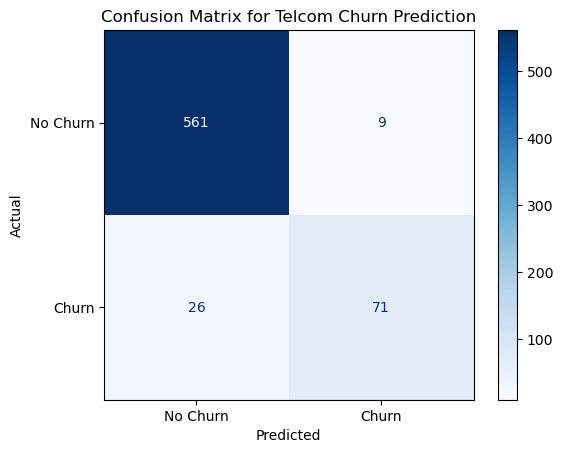

0.9475262368815592
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       570
           1       0.89      0.73      0.80        97

    accuracy                           0.95       667
   macro avg       0.92      0.86      0.89       667
weighted avg       0.95      0.95      0.95       667



In [74]:
clg_matrix = confusion_matrix(y_test, y_hat_test_clg)
labels = ['No Churn', 'Churn']
disp = ConfusionMatrixDisplay(confusion_matrix=clg_matrix, display_labels=labels)


disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Telcom Churn Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(accuracy_score(y_test, y_hat_test_clg))
print(classification_report(y_test, y_hat_test_clg))

In [70]:
print(f'Accuracy score: {accuracy_score(y_test, y_hat_test_clg)} \n') 
print(f'Recall score: {recall_score(y_test, y_hat_test_clg)} \n')

Accuracy score: 0.9475262368815592 

Recall score: 0.7319587628865979 

